In [1]:
from losses import *
from lr_scheduler import *
from models.ghost.ghost import *
from partial_fc_v2 import *
from dataset import *
from torch.utils.data import DataLoader
import torchvision.transforms as transfroms

# Data Preparation

In [2]:
data_src = '/home/duypham/WorkSpace/Generative_Projects/Face_Recognition/datasets/custom_dataset'

In [3]:
train_image_transforms=transfroms.Compose([
    transfroms.RandomHorizontalFlip(),
    transfroms.ToTensor(),
    transfroms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
image_transforms=transfroms.Compose([
    transfroms.ToTensor(),
    transfroms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [4]:
num_class = 1020

In [5]:
train_set=TrainFaceRegDataset(data_src,image_transforms,'train',112)
gallery_set=TrainFaceRegDataset(data_src,image_transforms,'gallery',112)
query_set=TrainFaceRegDataset(data_src,image_transforms,'query',112)

In [6]:
train_loader=DataLoader(train_set,128,shuffle=True)
gallery_loader=DataLoader(gallery_set,128,shuffle=False)
query_loader=DataLoader(query_set,128,shuffle=False)

# Define Model

In [7]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

backbone = FaceNet(embed_dim=768)
backbone.load_state_dict(torch.load('./ckpts/2/model_e_119.pt'))
# backbone.train()

<All keys matched successfully>

# Train

In [ ]:
epochs =50
total_iters=len(train_loader)*epochs

## loss and scheduler

In [ ]:
margin_loss = CombinedMarginLoss(64,1.0, 0.5, 0.00,0)
module_partial_fc = PartialFC_V2(
            margin_loss, 768, num_class,1,True)
module_partial_fc.train().cuda()
optimizer = torch.optim.AdamW(
    params=[{"params": backbone.parameters()}, {"params": module_partial_fc.parameters()}],
    lr=1e-4, weight_decay=0.1)
total_iters=len(train_loader)*epochs
lr_scheduler = PolynomialLRWarmup(
        optimizer=optimizer,
        warmup_iters=total_iters//10,
        total_iters=total_iters)

In [ ]:
from utils.load_model import *


In [ ]:
from tqdm import tqdm
from accelerate import Accelerator
from eval import eval_model
def train_loop(epochs, model,module_partial_fc, optimizer, train_dataloader,gallery_loader,query_loader, lr_scheduler,device='cuda',ckpt_path='./ckpts'):
    # Initialize accelerator and tensorboard logging
    model.to(device)
    module_partial_fc.to(device)
    accelerator = Accelerator(
        mixed_precision='fp16',
        gradient_accumulation_steps=1,
    )
    model,module_partial_fc, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model,module_partial_fc, optimizer, train_dataloader, lr_scheduler
    )

    global_steps=0
    # Now you train the model
    for epoch in range(epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        module_partial_fc.train()
        model.train()
        for step, (image,label) in enumerate(train_dataloader):
            global_steps+=1
            image = image.to(device)
            label=label.to(device)

            with accelerator.accumulate(model):
                img_emb = model(image)
                loss = module_partial_fc(img_emb, label)
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_steps}
            progress_bar.set_postfix(**logs)
        if epoch%50==0:
            unwarp_model=accelerator.unwrap_model(model)
            eval_board=eval_model(unwarp_model,gallery_loader,query_loader,device)
            print(eval_board)
            os.makedirs(ckpt_path,exist_ok=True)
            torch.save(unwarp_model.state_dict(), os.path.join(ckpt_path,'model_e_{epoch}.pt'))
            print('==>Save<==')


/home/duypham/miniconda3/envs/face-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from accelerate import notebook_launcher

# args = (epochs, backbone,module_partial_fc, optimizer, train_loader,gallery_loader,query_loader, lr_scheduler,'cuda','./ckpts')

# notebook_launcher(train_loop, args, num_processes=1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
import os
def visualize_tsne(model,train_loader, perplexity=5,device='cuda',save_path='./visualize_training',e=0):
    print('Saving png file...')
    os.makedirs(save_path,exist_ok=True)
    new_save_path=os.path.join(save_path,str(len(os.listdir(save_path))))
    os.makedirs(new_save_path,exist_ok=True)
    embeddings=[]
    labels=[]
    model.to(device)
    for image,label in train_loader:
        model.eval()
        with torch.inference_mode():
            image = image.to(device)
            label=label.to(device)

            embedding= model(image)
            embeddings.extend(F.normalize(embedding.detach().cpu(),dim=-1).numpy().tolist())
            labels.extend(label.detach().cpu().numpy().tolist())
            if len(embeddings)>300:
                break
    X = np.array(embeddings)
    y = np.array(labels)
    # t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200)
    X_tsne = tsne.fit_transform(X)

    # Normalize to unit circle
    norms = np.linalg.norm(X_tsne, ord=2, axis=1, keepdims=True)
    X_tsne = X_tsne / norms

    # Convert to DataFrame
    df = pd.DataFrame({
        "x": X_tsne[:, 0],
        "y": X_tsne[:, 1],
        "label": y
    })

    # Plot with seaborn
    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        data=df,
        x="x", y="y",
        hue="label",
        palette="tab20",
        legend=False
    )
    plt.title("t-SNE visualization of embeddings")
    # plt.savefig(os.path.join(new_save_path,f"tsne_plot_{e}.png"), dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
from eval import eval_model

Saving png file...


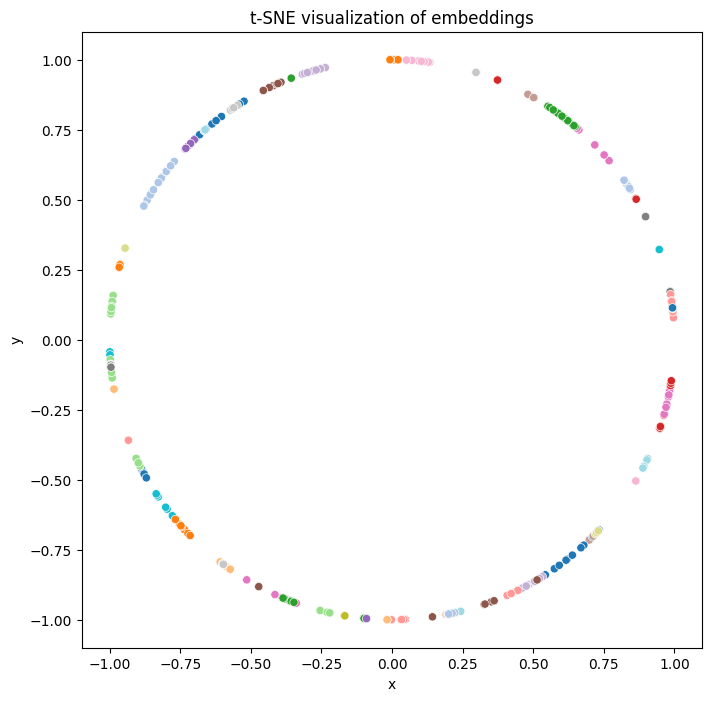

In [ ]:
visualize_tsne(backbone,gallery_loader,30)

In [ ]:
import faiss                   # make faiss available
index_IP = faiss.IndexFlatIP(768)
index_l2 = faiss.IndexFlatL2(768)

In [ ]:
arr = np.array([])

# lưu vào file npy
np.save("empty.npy", arr)

In [ ]:
import numpy as np
empty=np.load('empty.npy')


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
def compute_best_threshold(model,gallery_loader,query_loader,device='cuda'):
    with tqdm(total=len(gallery_loader)+len(query_loader)+4+len(gallery_loader)*gallery_loader.batch_size, desc="Running Eval") as pbar:
        model.to(device)
        model.eval()
        with torch.inference_mode():
            gallery_embs=[]
            gallery_labels=[]
            query_embs=[]
            query_labels=[]
            for (image,label) in gallery_loader:
                image=image.to(device)
                embs = model(image)
                gallery_embs.append(embs.detach())
                gallery_labels.append(label.detach())
                pbar.update(1)
            for (image,label) in query_loader:
                image=image.to(device)
                embs = model(image)
                query_embs.append(embs.detach())
                query_labels.append(label.detach())
                pbar.update(1)
            gallery_embs=F.normalize(torch.cat(gallery_embs),dim=-1).to(device)
            gallery_labels=torch.cat(gallery_labels).flatten().to(device)
            query_embs=F.normalize(torch.cat(query_embs),dim=-1).to(device)
            query_labels=torch.cat(query_labels).flatten().to(device)

            cosine_sim = query_embs@gallery_embs.T
            values,index=cosine_sim.topk(1,dim=-1)
            probs=values.flatten().detach().cpu().numpy()
            true_label=(gallery_labels[index].flatten()==query_labels).long().detach().cpu().numpy()

            fpr,tpr,threshold=roc_curve(true_label,probs)
            roc_auc = auc(fpr, tpr)
            print(threshold[np.argmax(tpr-fpr)])
            # Plot
            plt.figure(figsize=(6,6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random chance")

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver Operating Characteristic (ROC)")
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()

Running Eval:   1%|▏         | 72/4813 [00:06<06:27, 12.25it/s]

0.5896716


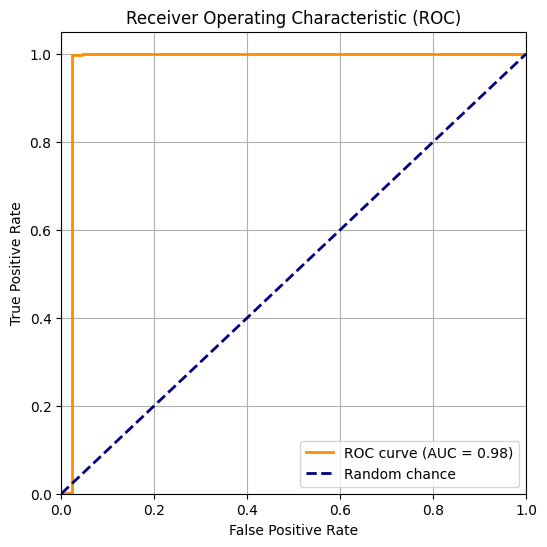

Running Eval:   2%|▏         | 73/4813 [00:06<06:47, 11.62it/s]



In [16]:
eval_model(backbone.cuda(),gallery_loader,query_loader,device='cuda')

In [ ]:
from facenet_pytorch import MTCNN
detector=MTCNN(112,keep_all=True)
def inferrence(img,model,detector,device='cpu'):
    if isinstance(img,str):
        img =cv2.imread(img,1)
    if img is None:
         raise ValueError("img or img path doesn't exist")
    else:
        img = cv2.cvtColor(
            cv2.resize(img,(112,112),interpolation=cv2.INTER_LANCZOS4),
            cv2.COLOR_BGR2RGB)
        arcface_template = np.array([
        [38.2946, 51.6963],  
        [73.5318, 51.5014],   
        [56.0252, 71.7366],   
        [41.5493, 92.3655],  
        [70.7299, 92.2041]   
        ], dtype=np.float32)
        # 2. Dùng MTCNN detect
        boxes, _= detector.detect(Image.fromarray(img), landmarks=False)
        if boxes is not None:
            x, y, w, h = boxes[0].astype(int)
            x1, y1 = max(1, x-1), max(1, y-1)
            x2, y2 = min(img.shape[1]-1, x + w-1), min(img.shape[0]-1, y + h-1)
            img = img[y1:y2,x1:x2,:]
            img=cv2.resize(img,(112,112),interpolation=cv2.INTER_LANCZOS4)
            _, _,landmarks= detector.detect(Image.fromarray(img), landmarks=True)
            if landmarks is not None:
                src_landmarks = np.array(landmarks[0], dtype=np.float32)
                img = align_face(img, src_landmarks, arcface_template, size=(112,112))
            plt.imshow(img)
            plt.show() 
            img = (transfroms.ToTensor()(img)-0.5)/0.5
            model.eval()
            model.to(device)
            emb= F.normalize(model(img.unsqueeze(0).to(device)).squeeze().flatten().detach().cpu(),p=2,dim=-1,eps=0).numpy()
            return emb       

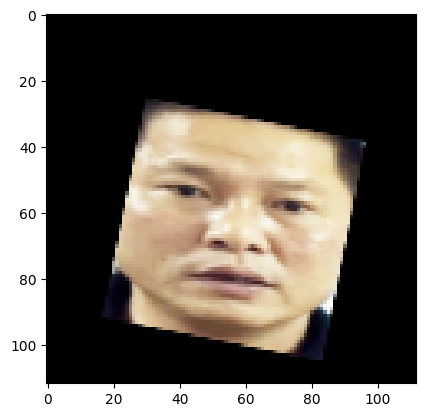

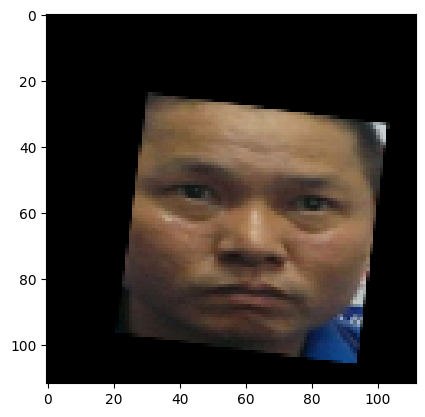

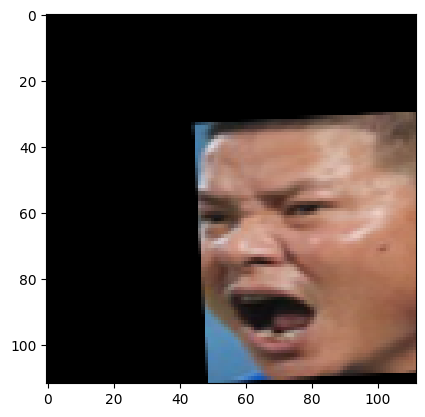

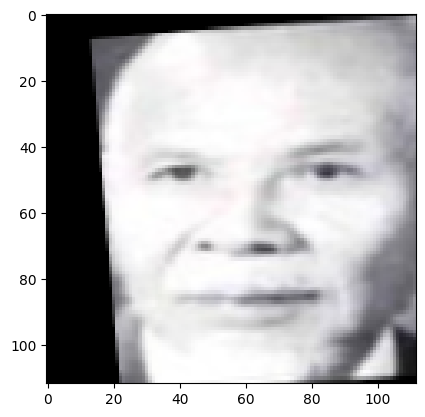

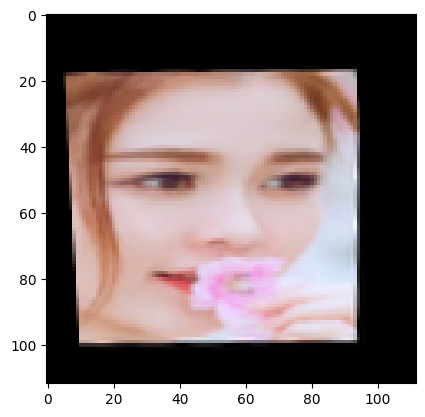

In [ ]:
emb_0=inferrence('/home/duypham/WorkSpace/Generative_Projects/Face_Recognition/datasets/VN-celeb/1/0.png',backbone,detector,device='cuda')
emb_0_1=inferrence('/home/duypham/WorkSpace/Generative_Projects/Face_Recognition/datasets/VN-celeb/1/20.png',backbone,detector,device='cuda')
emb_1=inferrence('/home/duypham/WorkSpace/Generative_Projects/Face_Recognition/datasets/VN-celeb/1/13.png',backbone,detector,device='cuda')
emb_2=inferrence('/home/duypham/WorkSpace/Generative_Projects/Face_Recognition/datasets/custom_dataset/train/2_4.png',backbone,detector,device='cuda')
emb_3=inferrence('/home/duypham/WorkSpace/Generative_Projects/Face_Recognition/datasets/custom_dataset/train/3_13.png',backbone,detector,device='cuda')

In [ ]:
index_IP.add(x=np.array([emb_1,emb_0_1,emb_2,emb_3]))

In [ ]:
index_IP.search(np.array([emb_0]),4)

(array([[0.32821918, 0.22690389, 0.22240208, 0.14312595]], dtype=float32),
 array([[1, 5, 0, 4]]))

In [ ]:
import faiss